## This code is to check if hdea direction cells in ADN and PoS recorded by Duszkiewicz et al, show firing rate adaptation.

In [1]:
import os
import numpy as np
from scipy.ndimage import convolve1d
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

import utils

%load_ext autoreload
%autoreload 2

In [2]:
def plot_head_direction_tuning(ax, angle_data, angle4spike, config, pos_tb=0.01):
    """
    Plot the head direction tuning map in a polar plot.

    Parameters:
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        The polar axes to plot on.
    ppoh : np.array
        Array of session head direction angles in degrees.
    psph : np.array
        Array of cell head direction angles in degrees.
    pos_tb : float
        Time base for converting session HD to time.
    cell_name : str
        Name of the cell for which the tuning map is plotted.
    config : dict
        Configuration dictionary containing 'hd_bins' and 'hd_boxcar' parameters.
    """


    # Calculate histograms for session and cell head directions
    hd1, _ = np.histogram(angle_data, bins=config['hd_bins'], range=(-np.pi, np.pi))
    hd2, _ = np.histogram(angle4spike, bins=config['hd_bins'], range=(-np.pi, np.pi))

    # Boxcar filter
    boxcar_size = config['hd_boxcar']
    boxcar_filter = np.ones(boxcar_size) / boxcar_size

    # Apply boxcar filter
    hd1_filtered = convolve1d(hd1, boxcar_filter, mode='wrap')
    hd2_filtered = convolve1d(hd2, boxcar_filter, mode='wrap')

    # Convert session HD to time (i.e., dwelling time in each HD bin)
    hd1_time = hd1_filtered * pos_tb

    # Calculate HD firing rate
    hd3 = hd2_filtered / hd1_time
    # #where hd3 is nan, set it to 0
    # hd3 = np.nan_to_num(hd3)
    
    # Normalize session HD
    hd1_normalized = hd1_time / np.max(hd1_time)

    # Normalize cell HD firing rate
    hd3_normalized = hd3 / np.nanmax(hd3)
    hd3_normalized = hd3_normalized.flatten()

    # Close the loop by appending the first element to the end
    theta = np.linspace(-np.pi, np.pi, config['hd_bins'], endpoint=False)
    theta = np.append(theta, theta[0])
    hd1_normalized = np.append(hd1_normalized, hd1_normalized[0])
    hd3_normalized = np.append(hd3_normalized, hd3_normalized[0])

    # Plot the session head direction with shading
    ax.plot(theta, hd1_normalized, label='Session Head Direction', color='gray')
    ax.fill_between(theta, 0, hd1_normalized, facecolor='gray', alpha=0.2)

    # Plot the cell head direction firing rate
    ax.plot(theta, hd3_normalized, label='Cell Head Direction Firing Rate', color='#38c7ff')
    ax.fill_between(theta, 0, hd3_normalized, facecolor='#38c7ff', alpha=0.5)

    #keep 0 90 180 270 as the xticks
    ax.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2])
    ax.set_xticklabels(['0', '90', '180', '270'])
    
    #remove yticks
    ax.set_yticks([])
    
    #calculate the preferred direction which corresponds to the peak of the tuning curve
    prefer_hd = theta[np.argmax(hd3_normalized)]
    #add a line to indicate the preferred direction
    ax.plot([prefer_hd, prefer_hd], [0, 1], color='red', linestyle='--', linewidth=1)
    
    return ax, prefer_hd

def get_adaptation(angle_data, t, spiket, prefer_hd, degreerange=6, timelength=0.33, timecut=0.16):
    """
    Calculate adaptation based on periods when head direction (ppoh) is within the preferred range.

    Parameters:
        ppoh (numpy array): Rat head direction (in degrees).
        t (numpy array): Timestamps for ppoh.
        psph: Head direction when a spike occurs.
        pspt: Accurate time when a spike occurs.
        prefer_hd (float): Preferred direction (in radians).
        degreerange (int): Range around the preferred direction to consider (in degrees).

    Returns:
        list: A list of tuples where each tuple contains the start time, end time of a continuous period, 
              and the spike times within that period.
    """
    # Convert angle_data from radians to degrees and wrap it to 0-360
    angle_data = np.rad2deg(angle_data)
    
    # Convert preferred direction from radians to degrees
    preferred_direction = np.rad2deg(prefer_hd)

    # Calculate the wrapped difference between ppoh and preferred_direction
    diff = (angle_data - preferred_direction + 180) % 360 - 180

    # Assign True if the wrapped difference is within the degreerange, else False
    in_range = np.abs(diff) <= degreerange

    # Find the start and end indices of continuous periods using np.diff and np.where
    changes = np.diff(in_range.astype(int))
    start_indices = np.where(changes == 1)[0] + 1
    end_indices = np.where(changes == -1)[0]

    # Handle cases where the first or last period is continuous
    if in_range[0]:
        start_indices = np.insert(start_indices, 0, 0)
    if in_range[-1]:
        end_indices = np.append(end_indices, len(in_range) - 1)

    # Extract spike times within each continuous period
    
    inst_fr = []
    durations = []
    
    count = 0
    for start, end in zip(start_indices, end_indices):
        start_time = t[start]
        end_time = t[end]
        
        #if end_time - start_time < 0.3: do not consider this period
        if end_time - start_time < timelength or end_time - start_time > 2:
        # if end_time - start_time > 2:
            continue
        
        # #consider only those head rotating periods when entering from one side and leaving from the other side
        anglewithinrange = angle_data[start:end]-preferred_direction
        # #the sign of the anglewithinrange should be different at the start and end
        if anglewithinrange[0] * anglewithinrange[-1] > 0:
            continue
        
        count += 1 
        
        timecut = (end_time - start_time) / 2
        
        #count the number of spikes between start_time and start_time + timelength/2
        spikes_in_period_firsthalf = spiket[(spiket >= start_time) & (spiket <= start_time+timecut)]
        
        #count the number of spikes between start_time + timelength/2 and start_time + timelength
        spikes_in_period_secondhalf = spiket[(spiket > end_time - timecut) & (spiket <= end_time)]
        
        # Ensure at least two spikes exist in each window
        if len(spikes_in_period_firsthalf) < 1 or len(spikes_in_period_secondhalf) < 1:
            continue
        
        # Ensure ISI calculation doesn't include zero values
        # don't know why, but happen few times....
        if 0 in np.diff(spikes_in_period_firsthalf) or 0 in np.diff(spikes_in_period_secondhalf):
            continue

        # #calculate the instantaneous firing rate
        # initial_instfr = np.mean(1./np.diff(spikes_in_period_firsthalf))
        # final_instfr = np.mean(1./np.diff(spikes_in_period_secondhalf))
        
        #calculate the mean firing rate
        initial_instfr = len(spikes_in_period_firsthalf) / timecut
        final_instfr = len(spikes_in_period_secondhalf) / timecut
        
        inst_fr.append((initial_instfr, final_instfr))
        durations.append(end_time - start_time)
    
    return inst_fr, durations

def extract_initial_final_instfr(instfr, takewithincellmean=False):
    initial_instfr = []
    final_instfr = []
    if takewithincellmean is False:
        for i in range(len(instfr)):
            if len(instfr[i]) == 0:
                continue
            else:
                for j in range(len(instfr[i])):
                    initial_instfr.append(instfr[i][j][0])
                    final_instfr.append(instfr[i][j][1])
    else:
        for i in range(len(instfr)):
            if len(instfr[i]) == 0:
                continue
            else:
                initial_instfr.append(np.mean([instfr[i][j][0] for j in range(len(instfr[i]))]))
                final_instfr.append(np.mean([instfr[i][j][1] for j in range(len(instfr[i]))]))
    return initial_instfr, final_instfr

def extract_dur(dur):
    #dur is a list of list
    #change to a list
    durations = []
    for i in range(len(dur)):
        if len(dur[i]) == 0:
            continue
        else:
            for j in range(len(dur[i])):
                durations.append(dur[i][j])
    return durations

def get_adaptation_for_all(datafolder, area, degreerange, timelength, timecut, return_mean=False):
    '''
    Input: brainarea: adn or pos
    '''
    
    allcell_instfr = []
    allcell_dur = []

    # all folders in /home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_5
    animalfolders = os.listdir(datafolder)

    for folder in animalfolders:
        mousetrial = datafolder + folder + '/Data'
        
        print('Processing ' + folder)
        
        #load data
        data = utils.load_data(mousetrial)
        t = data['t']
        
        # #check if t has regular intervals if not, print
        # if np.all(np.diff(t) == np.diff(t)[0]) is False:
        #     print('Time intervals are not regular')
        
        angle_data = data['angle_data']
        brainarea = data[area] 
        hd = data['hd']
        # idx = np.where(brainarea == 1)[0]
        spike_times = data['spike_times']
        # spike_times = [spike_times[i] for i in idx]
        
        # Configuration
        config = {
            'hd_bins': 60,
            'hd_boxcar': 3,
        }
        
        #plot all directional tuning
        fig = plt.figure(figsize=(2*len(spike_times),2))
        for i in range(len(spike_times)):
            spike_time_cell_i = spike_times[i]
            spike_array_cell_i = utils.compute_spike_array(spike_time_cell_i, t)

            #calculate the head direction angle when spike_array_cell_i is not zero
            angle4spike = angle_data[spike_array_cell_i != 0]

            ax = fig.add_subplot(1,len(spike_times),i+1, polar=True)
            ax, prefer_hd = plot_head_direction_tuning(ax, angle_data, angle4spike, config)

            #calculate firing rate adaptation
            inst_fr, dur = get_adaptation(angle_data, t, spike_time_cell_i, prefer_hd, degreerange=degreerange, timelength=timelength, timecut=timecut)

            #if cell is a hd and adn cell then save the inst_fr and dur
            if hd[i] == 1 and brainarea[i] == 1:
                allcell_instfr.append(inst_fr)
                allcell_dur.append(dur)

        plt.close()
        
    #extract initial and final instfr
    initial_instfr, final_instfr = extract_initial_final_instfr(allcell_instfr, takewithincellmean=True)
    durations = extract_dur(allcell_dur)
    
    if return_mean:
        return np.mean(initial_instfr), np.mean(final_instfr), np.mean(durations)
    else:
        return initial_instfr, final_instfr, durations

### check one cell example

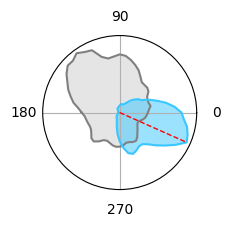

In [3]:
mousetrial = '/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_5/A1104-180328/Data'

#load data
data = utils.load_data(mousetrial)

t = data['t']
angle_data = data['angle_data']

adn = data['adn']
hd = data['hd']

idx = np.where((adn == 1) & (hd==1))[0]

spike_times = data['spike_times']

spike_times = [spike_times[i] for i in idx]

# Configuration
config = {
    'hd_bins': 60,
    'hd_boxcar': 3,
}
degreerange = 15 #Taube & Muller 1998
timecut = 0.15 #Taube & Muller 1998
timelength = 2*timecut

#angle4spike
spike_time_cell_i = spike_times[0]
spike_array_cell_i = utils.compute_spike_array(spike_time_cell_i, t)

#calculate the head direction angle when spike_array_cell_i is not zero
angle4spike = angle_data[spike_array_cell_i != 0]

fig = plt.figure(figsize=(2,2))

ax = fig.add_subplot(111, polar=True)
ax, prefer_hd = plot_head_direction_tuning(ax, angle_data, angle4spike, config)

#caulcate firing rate adaptation 
inst_fr, dur = get_adaptation(angle_data, t, spike_time_cell_i, prefer_hd, degreerange=degreerange, timelength=timelength, timecut=timecut)



### check all HD cells in ADN (Dataset_5)

In [4]:
degreerange = 10 #Taube & Muller 1998
timecut = 0.2 #Taube & Muller 1998~
timelength = 0.01 #2*timecut

datafolder = '/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_5/'
area = 'adn'
initial_instfr, final_instfr, durations = get_adaptation_for_all(datafolder, 
                                                                 area,
                                                                 degreerange, 
                                                                 timelength, 
                                                                 timecut, 
                                                                 return_mean=False)

print('Initial firing rate: {:.2f} +- {:.2f} Final firing rate: {:.2f} +- {:.2f}'.format(np.mean(initial_instfr), 
                                                                         np.std(initial_instfr)/np.sqrt(len(initial_instfr)),
                                                                         np.mean(final_instfr), 
                                                                         np.std(final_instfr)/np.sqrt(len(final_instfr))))

##perform a wilcoxon signed rank test
stat, p = wilcoxon(np.array(initial_instfr), np.array(final_instfr))
print('Statistics=%.3f, p=%.3f' % (stat, p))

print('number of head direction cell in adn: ', len(initial_instfr))

Processing A1106-180419
Processing A1110-180626
Processing A1113-180813
Processing A1106-180418
Processing A1110-180619
Processing A1113-180814
Processing A1110-180617
Processing A1112-180711
Processing A1110-180621
Processing A1104-180329
Processing A1110-180613
Processing A1112-180709
Processing A1104-180328
Processing B0703-211208
Processing B0201-210922
Processing A1113-180816
Processing A1109-180619
Processing A1110-180612
Processing A1109-180615
Initial firing rate: 51.11 +- 3.43 Final firing rate: 49.70 +- 3.28
Statistics=1036.000, p=0.000
number of head direction cell in adn:  93


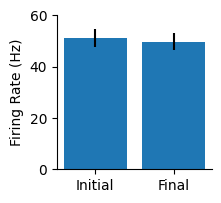

In [5]:
#do a bar plot of the initial and final firing rate with mean and sem
fig, ax = plt.subplots(figsize=(2,2))
ax.bar(['Initial', 'Final'], 
        [np.mean(initial_instfr), np.mean(final_instfr)], 
        yerr=[np.std(initial_instfr)/np.sqrt(len(initial_instfr)), np.std(final_instfr)/np.sqrt(len(final_instfr))])
ax.set_ylabel('Firing Rate (Hz)')

#ylim = 70-90
ax.set_ylim([0, 60])

#spines off
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### check all HD cells in PoS (Dataset_2)

In [9]:
degreerange = 10 #Taube & Muller 1998
timecut = 0.2 #Taube & Muller 1998
timelength = 0.01

datafolder = '/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_2/'
area = 'pos'

initial_instfr, final_instfr, durations = get_adaptation_for_all(datafolder, 
                                                                 area,
                                                                 degreerange, 
                                                                 timelength, 
                                                                 timecut, 
                                                                 return_mean=False)

print('Initial firing rate: {:.2f} +- {:.2f} Final firing rate: {:.2f} +- {:.2f}'.format(np.mean(initial_instfr), 
                                                                         np.std(initial_instfr)/np.sqrt(len(initial_instfr)),
                                                                         np.mean(final_instfr), 
                                                                         np.std(final_instfr)/np.sqrt(len(final_instfr))))

##perform a wilcoxon signed rank test
stat, p = wilcoxon(np.array(initial_instfr), np.array(final_instfr))
print('Statistics=%.3f, p=%.3f' % (stat, p))


print('number of head direction cell in pos: ', len(initial_instfr))

Processing A5507-200920
Processing A9701-210805
Processing A5508-200930
Processing A6215-210610
Processing A1824-190827


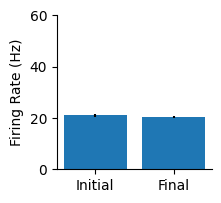

In [7]:
#do a bar plot of the initial and final firing rate with mean and sem
fig, ax = plt.subplots(figsize=(2,2))
ax.bar(['Initial', 'Final'], 
        [np.mean(initial_instfr), np.mean(final_instfr)], 
        yerr=[np.std(initial_instfr)/np.sqrt(len(initial_instfr)), np.std(final_instfr)/np.sqrt(len(final_instfr))])
ax.set_ylabel('Firing Rate (Hz)')

#ylim = 70-90
ax.set_ylim([0, 60])

#spines off
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [8]:
#subsample 97 cells from the pos dataset and redo the stats
np.random.seed(0)

for i in range(100):
    idx = np.random.choice(np.arange(len(initial_instfr)), 100, replace=False)

    initial_instfr_subsample = [initial_instfr[i] for i in idx]
    final_instfr_subsample = [final_instfr[i] for i in idx]

    ##perform a wilcoxon signed rank test
    stat, p = wilcoxon(np.array(initial_instfr_subsample), np.array(final_instfr_subsample))
    print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=2167.000, p=0.218
Statistics=1999.000, p=0.071
Statistics=1919.000, p=0.037
Statistics=1834.000, p=0.018
Statistics=1908.000, p=0.034
Statistics=2065.000, p=0.114
Statistics=2020.000, p=0.083
Statistics=2382.000, p=0.623
Statistics=2136.000, p=0.181
Statistics=2016.000, p=0.080
Statistics=1817.000, p=0.015
Statistics=2076.000, p=0.123
Statistics=2242.000, p=0.331
Statistics=2140.000, p=0.186
Statistics=2097.000, p=0.141
Statistics=2149.000, p=0.196
Statistics=1747.000, p=0.007
Statistics=1954.000, p=0.050
Statistics=1807.000, p=0.014
Statistics=2113.000, p=0.157
Statistics=2150.000, p=0.197
Statistics=1636.000, p=0.002
Statistics=1838.000, p=0.018
Statistics=1832.000, p=0.017
Statistics=2432.000, p=0.749
Statistics=2216.000, p=0.288
Statistics=2020.000, p=0.083
Statistics=2009.000, p=0.076
Statistics=2479.000, p=0.874
Statistics=2150.000, p=0.197
Statistics=1998.000, p=0.070
Statistics=1916.000, p=0.036
Statistics=2464.000, p=0.834
Statistics=2277.000, p=0.394
Statistics=208

### check all HD cells in PoS (Dataset_1)

In [39]:
degreerange = 20 #Taube & Muller 1998 used 6 here
timecut = 0.1 #Taube & Muller 1998 used 0.16 here
timelength = 0.01 #2*timecut

datafolder = '/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_1/'
area = 'pos'

initial_instfr, final_instfr, durations = get_adaptation_for_all(datafolder, 
                                                                 area,
                                                                 degreerange, 
                                                                 timelength, 
                                                                 timecut, 
                                                                 return_mean=False)

print('Initial firing rate: {:.2f} +- {:.2f} Final firing rate: {:.2f} +- {:.2f}'.format(np.mean(initial_instfr), 
                                                                         np.std(initial_instfr)/np.sqrt(len(initial_instfr)),
                                                                         np.mean(final_instfr), 
                                                                         np.std(final_instfr)/np.sqrt(len(final_instfr))))

##perform a wilcoxon signed rank test
stat, p = wilcoxon(np.array(initial_instfr), np.array(final_instfr))
print('Statistics=%.3f, p=%.3f' % (stat, p))

print('number of head direction cell in pos: ', len(initial_instfr))



Processing A3709-200601
Processing A3713-200909a
Processing A3703-191215
Processing A3728-210309b
Processing A3730-210323b
Processing A3705-200306
Processing A3708-200317b
Processing A3706-200313
Processing A3723-201115
Processing A3717-201021
Processing A3712-200903a
Processing A3711-200810b
Processing A3710-200609
Processing A3701-191119
Processing A3707-200317
Processing A3702-191126
Processing A3716-201015b
Initial firing rate: 22.64 +- 0.30 Final firing rate: 21.63 +- 0.28
Statistics=155733.000, p=0.000
number of head direction cell in pos:  1031


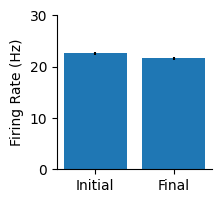

In [40]:
#do a bar plot of the initial and final firing rate with mean and sem
fig, ax = plt.subplots(figsize=(2,2))
ax.bar(['Initial', 'Final'], 
        [np.mean(initial_instfr), np.mean(final_instfr)], 
        yerr=[np.std(initial_instfr)/np.sqrt(len(initial_instfr)), np.std(final_instfr)/np.sqrt(len(final_instfr))])
ax.set_ylabel('Firing Rate (Hz)')

#ylim = 70-90
ax.set_ylim([0, 30])

#spines off
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [42]:
#subsample 97 cells from the pos dataset and redo the stats
np.random.seed(0)

for i in range(100):
    idx = np.random.choice(np.arange(len(initial_instfr)), 100, replace=False)

    initial_instfr_subsample = [initial_instfr[i] for i in idx]
    final_instfr_subsample = [final_instfr[i] for i in idx]

    ##perform a wilcoxon signed rank test
    stat, p = wilcoxon(np.array(initial_instfr_subsample), np.array(final_instfr_subsample))
    print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1566.000, p=0.001
Statistics=1321.000, p=0.000
Statistics=1652.000, p=0.003
Statistics=1677.000, p=0.004
Statistics=1454.000, p=0.000
Statistics=1462.000, p=0.000
Statistics=1508.000, p=0.000
Statistics=1491.000, p=0.000
Statistics=1145.000, p=0.000
Statistics=1628.000, p=0.002
Statistics=1446.000, p=0.000
Statistics=1831.000, p=0.017
Statistics=1328.000, p=0.000
Statistics=1609.000, p=0.002
Statistics=1586.000, p=0.001
Statistics=1327.000, p=0.000
Statistics=1770.000, p=0.009
Statistics=1538.000, p=0.001
Statistics=1440.000, p=0.000
Statistics=1636.000, p=0.002
Statistics=1705.000, p=0.005
Statistics=1366.000, p=0.000
Statistics=1700.000, p=0.005
Statistics=1272.000, p=0.000
Statistics=1913.000, p=0.035
Statistics=1558.000, p=0.001
Statistics=1859.000, p=0.022
Statistics=1581.000, p=0.001
Statistics=1821.000, p=0.015
Statistics=1350.000, p=0.000
Statistics=1299.000, p=0.000
Statistics=1459.000, p=0.000
Statistics=1420.000, p=0.000
Statistics=1168.000, p=0.000
Statistics=125

## Let's do parameter search...

In [14]:
datafolder = '/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_5/'
area = 'adn'

#varying degreerange from 6 to 20 2 is the step
degreeranges = np.arange(6, 30, 3)
#varying timecut from 0.10 to 0.50 0.05 is the step
timecuts = np.arange(0.10, 0.5, 0.05)

PVal_table = np.zeros((len(degreeranges), len(timecuts)))
FRdiff_table = np.zeros((len(degreeranges), len(timecuts)))

for i, degreerange in enumerate(degreeranges):
    for j, timecut in enumerate(timecuts):
        timelength = 2*timecut
        print(degreerange, timelength, timecut)
        initial_instfr, final_instfr, durations = get_adaptation_for_all(datafolder, 
                                                                        area,
                                                                        degreerange, 
                                                                        timelength, 
                                                                        timecut, 
                                                                        return_mean=False)
        FRdiff_table[i, j] = np.mean(initial_instfr) - np.mean(final_instfr)


6 0.2 0.1
Processing A1106-180419
Processing A1110-180626
Processing A1113-180813
Processing A1106-180418
Processing A1110-180619
Processing A1113-180814
Processing A1110-180617
Processing A1112-180711
Processing A1110-180621
Processing A1104-180329
Processing A1110-180613
Processing A1112-180709
Processing A1104-180328
Processing B0703-211208
Processing B0201-210922
Processing A1113-180816
Processing A1109-180619
Processing A1110-180612
Processing A1109-180615
6 0.30000000000000004 0.15000000000000002
Processing A1106-180419
Processing A1110-180626
Processing A1113-180813
Processing A1106-180418
Processing A1110-180619
Processing A1113-180814
Processing A1110-180617
Processing A1112-180711
Processing A1110-180621
Processing A1104-180329
Processing A1110-180613
Processing A1112-180709
Processing A1104-180328
Processing B0703-211208
Processing B0201-210922
Processing A1113-180816
Processing A1109-180619
Processing A1110-180612
Processing A1109-180615
6 0.4000000000000001 0.2000000000000

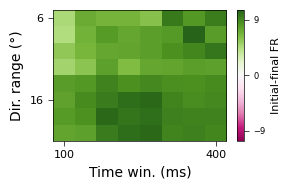

In [16]:
fig, ax = plt.subplots(figsize=(3,2))
labelsize = 10
ticksize = 8

#plot the FRdiff_table, with positive as red and negative as blue
# ax = axs[1]
ax.imshow(FRdiff_table, cmap='PiYG', interpolation='none', vmin=-np.max(FRdiff_table), vmax=np.max(FRdiff_table))
# ax.set_title('Entry: Initial-Final FR', fontsize=labelsize)  
#add colorbar
cbar = fig.colorbar(ax.imshow(FRdiff_table, cmap='PiYG', interpolation='none', vmin=-np.max(FRdiff_table), vmax=np.max(FRdiff_table)), shrink=1.0, orientation='vertical')
cbar.set_label('Initial-final FR', fontsize=ticksize)
cbar.set_ticks([-9,0,9])
cbar.ax.tick_params(labelsize=ticksize-2)
ax.set_xlabel('Time win. (ms)', fontsize=labelsize)
#cbar tick bar width to 0.5
cbar.ax.tick_params(width=0.5)
#cbar spine width to 0.5
cbar.outline.set_linewidth(0.5)


#varying degreerange from 6 to 20 2 is the step
degreeranges = np.arange(6, 18, 2)
#varying timecut from 0.10 to 0.50 0.05 is the step
timecuts = np.arange(0.10, 0.50, 0.05)

# #add x and y labels
# for ax in axs:
    
ax.set_ylabel('Dir. range (°)', fontsize=labelsize)
#set tick size as ticksize
ax.tick_params(axis='both', labelsize=ticksize)
#auto axis
ax.axis('auto')
#set xticks and ticklabels
ax.set_xticks([0, len(timecuts)-1])
ax.set_xticklabels([str(int(timecuts[0]*1000)), str(int(timecuts[-2]*1000))])
#set yticls and ticklabels
ax.set_yticks([0, len(degreeranges)-1])
ax.set_yticklabels([str(degreeranges[0]), str(degreeranges[-1])])
#axis spines pt to 0
ax.spines['top'].set_linewidth(0.5)
ax.spines['right'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)

#tick bar width to 0.5
ax.tick_params(width=0.5)

plt.tight_layout()


6 0.2 0.1
Processing A5507-200920
Processing A9701-210805
Processing A5508-200930
Processing A6215-210610
Processing A1824-190827
Processing A1813-190408
Processing A5506-200914a
Processing A6216-210623
Processing A1808-190807
Processing A6211-210407
Processing A1821-190910
Processing A5505-200831
Processing A1815-190523
Processing A5801-200924
6 0.4 0.2
Processing A5507-200920
Processing A9701-210805
Processing A5508-200930
Processing A6215-210610
Processing A1824-190827
Processing A1813-190408
Processing A5506-200914a
Processing A6216-210623
Processing A1808-190807
Processing A6211-210407
Processing A1821-190910
Processing A5505-200831
Processing A1815-190523
Processing A5801-200924
6 0.6000000000000001 0.30000000000000004
Processing A5507-200920
Processing A9701-210805
Processing A5508-200930
Processing A6215-210610
Processing A1824-190827
Processing A1813-190408
Processing A5506-200914a
Processing A6216-210623
Processing A1808-190807
Processing A6211-210407
Processing A1821-190910


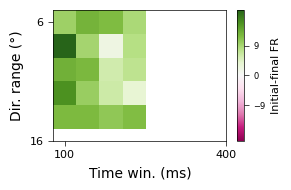

In [3]:
datafolder = '/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_2/'
area = 'pos'

#varying degreerange from 6 to 20 2 is the step
degreeranges = np.arange(6, 30, 5)
#varying timecut from 0.10 to 0.50 0.05 is the step
timecuts = np.arange(0.10, 0.5, 0.1)

PVal_table = np.zeros((len(degreeranges), len(timecuts)))
FRdiff_table = np.zeros((len(degreeranges), len(timecuts)))

for i, degreerange in enumerate(degreeranges):
    for j, timecut in enumerate(timecuts):
        timelength = 2*timecut
        print(degreerange, timelength, timecut)
        initial_instfr, final_instfr, durations = get_adaptation_for_all(datafolder, 
                                                                        area,
                                                                        degreerange, 
                                                                        timelength, 
                                                                        timecut, 
                                                                        return_mean=False)
        FRdiff_table[i, j] = np.mean(initial_instfr) - np.mean(final_instfr)
        

fig, ax = plt.subplots(figsize=(3,2))
labelsize = 10
ticksize = 8

#plot the FRdiff_table, with positive as red and negative as blue
# ax = axs[1]
ax.imshow(FRdiff_table, cmap='PiYG', interpolation='none', vmin=-np.max(FRdiff_table), vmax=np.max(FRdiff_table))
# ax.set_title('Entry: Initial-Final FR', fontsize=labelsize)  
#add colorbar
cbar = fig.colorbar(ax.imshow(FRdiff_table, cmap='PiYG', interpolation='none', vmin=-np.max(FRdiff_table), vmax=np.max(FRdiff_table)), shrink=1.0, orientation='vertical')
cbar.set_label('Initial-final FR', fontsize=ticksize)
cbar.set_ticks([-9,0,9])
cbar.ax.tick_params(labelsize=ticksize-2)
ax.set_xlabel('Time win. (ms)', fontsize=labelsize)
#cbar tick bar width to 0.5
cbar.ax.tick_params(width=0.5)
#cbar spine width to 0.5
cbar.outline.set_linewidth(0.5)


#varying degreerange from 6 to 20 2 is the step
degreeranges = np.arange(6, 18, 2)
#varying timecut from 0.10 to 0.50 0.05 is the step
timecuts = np.arange(0.10, 0.50, 0.05)

# #add x and y labels
# for ax in axs:
    
ax.set_ylabel('Dir. range (°)', fontsize=labelsize)
#set tick size as ticksize
ax.tick_params(axis='both', labelsize=ticksize)
#auto axis
ax.axis('auto')
#set xticks and ticklabels
ax.set_xticks([0, len(timecuts)-1])
ax.set_xticklabels([str(int(timecuts[0]*1000)), str(int(timecuts[-2]*1000))])
#set yticls and ticklabels
ax.set_yticks([0, len(degreeranges)-1])
ax.set_yticklabels([str(degreeranges[0]), str(degreeranges[-1])])
#axis spines pt to 0
ax.spines['top'].set_linewidth(0.5)
ax.spines['right'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)

#tick bar width to 0.5
ax.tick_params(width=0.5)

plt.tight_layout()

